In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import time
import random
import datetime
import os
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from torch import Tensor
import functools
from torchvision import datasets, transforms
from torch.nn.modules.loss import _Loss
from torch.utils.data import DataLoader
import torchvision
from model.drn import drn_d_54, drn_d_base
from model.CBAM import drn_d_CBAM
from model.resnet import ResNet50 as resnet
from model.efficientnet import *
from load_data import *
from optimizer import Ranger
from collections import Counter
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import recall_score,accuracy_score, precision_score,f1_score

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-o8s0q658 because the default path (/home/ubuntu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
In /home/ubuntu/tensorflow/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/ubuntu/tensorflow/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/ubuntu/tensorflow/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is dep

PyTorch Version:  1.5.0+cu101
Torchvision Version:  0.6.0+cu101


In [2]:
from torch.autograd import Variable
from torch.autograd import Function
from torchvision import models
from torchvision import utils
import cv2
import sys

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0)
test_size = 0.2
valid_size = 0.3
train_size = 0.5
batch_size = 4
test_bs = 4
random.seed(time.time())

In [19]:
class Focal_Loss(_Loss):
    def __init__(self, alpha = 1 , gamma = 1 , logits = False, reduce = False, ignore_index=10000, from_logits=False):
        super(Focal_Loss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.logits = logits
        self.reduce = reduce
        self.loss  = nn.BCELoss(weight = torch.Tensor([3.0, 1.0]).to(device))
    def forward(self, inputs, targets):
        #CE = F.cross_entropy(inputs, targets, weight = torch.Tensor([1.0, 4.0]).to(device), ignore_index=self.ignore_index)
        inputs = torch.sigmoid(inputs)
        #print(inputs.shape, targets.shape)
        CE = self.loss(inputs, targets)
        pt = torch.exp(-CE)
        F_loss = self.alpha * (1-pt)**self.gamma * CE

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

class Hswish(nn.Module):
    def forward(self, x):
        swish = F.relu6(x + 3 , inplace = True)
        return x* swish/6.

class conv_set(nn.Module):
    """docstring for conv_set"""
    def __init__(self, in_ch, out_ch, kernel_size, stride, padding):
        super(conv_set, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding, bias = False),
            nn.BatchNorm2d(out_ch),
            Hswish()
            )
    def forward(self, x):
        out = self.conv(x)
        return out

class A_net(nn.Module):

    def __init__(self, classes):
        super(A_net, self).__init__()
        self.classes = classes
        self.conv  = nn.Conv2d(1, 3, 1, 1, 0)
        self.conv1 = conv_set(3,12,3,1,0)
        self.conv2 = conv_set(12,16,3,1,0)
        self.conv3 = conv_set(16,32,3,1,0)
        self.conv4 = conv_set(32,classes,3,1,2)
        #self.conv5 = conv_set(64,classes,3,1,0)
    def forward(self, x):
        x = self.conv(x)
        out = self.conv1(x)
        out = F.max_pool2d(out, 2,2)
        out = self.conv2(out)
        out = F.max_pool2d(out, 2,2)
        out = self.conv3(out)
        out = F.max_pool2d(out, 2,2)
        out = self.conv4(out)
        return out 

class CNNX3(nn.Module):
    
    def __init__(self, backbone = 'drn', out_stride = 16, num_class = 2):
        super(CNNX3, self).__init__()
        
        if backbone == 'drn':
            output_stride = 8
        #self.drn = drn_d_base(nn.BatchNorm2d)
        #self.drn = gc_drn_54(nn.BatchNorm2d)
        #self.model = mixnet_l()
        self.model_d = drn_d_CBAM(nn.BatchNorm2d)
        self.model_l = drn_d_CBAM(nn.BatchNorm2d)
        self.model_m = drn_d_CBAM(nn.BatchNorm2d)
        #self.attention = A_net(512)
        #self.conv_out = nn.Conv2d(512,2,1)
        self.avgpool = nn.AdaptiveAvgPool2d(2)
        self._dropout = nn.Dropout(0.25)
        #self.fc = nn.Linear(2048, 2)
        self.fc = nn.Linear(6144, 2)
        


    def forward(self, input_def, input_lung,input_m):
        d = self.model_d(input_def)
        d = self.avgpool(d)
        l = self.model_l(input_lung)
        l = self.avgpool(l)
        m = self.model_m(input_m)
        m = self.avgpool(m)
        x = torch.cat((d.view(d.size(0), -1),
                          l.view(l.size(0), -1),m.view(m.size(0), -1)), dim=1)
       #atten = self.attention(input)
       #atten = torch.sigmoid(atten)
       #x = torch.mul(x, atten)
        #x = self.conv_out(x)
        #x = self.avgpool(x)
        #x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self._dropout(x)

        return x    
    
class CNNX1(nn.Module):
    
    def __init__(self, backbone = 'drn', out_stride = 16, num_class = 2):
        super(CNNX1, self).__init__()
        
        if backbone == 'drn':
            output_stride = 8
        #self.drn = drn_d_base(nn.BatchNorm2d)
        #self.drn = gc_drn_54(nn.BatchNorm2d)
        #self.model = mixnet_l()
        self.model_d = drn_d_CBAM(nn.BatchNorm2d)
        self.model_l = drn_d_CBAM(nn.BatchNorm2d)
        #self.model_m = drn_d_CBAM(nn.BatchNorm2d)
        #self.attention = A_net(512)
        #self.conv_out = nn.Conv2d(512,2,1)
        self.avgpool = nn.AdaptiveAvgPool2d(2)
        self._dropout = nn.Dropout(0.25)
        #self.fc = nn.Linear(2048, 2)
        self.fc = nn.Linear(4096, 2)
        


    def forward(self, input_def, input_lung):
        d = self.model_d(input_def)
        d = self.avgpool(d)
        l = self.model_l(input_lung)
        l = self.avgpool(l)
        #m = self.model_m(input_m)
        #m = self.avgpool(m)
        x = torch.cat((d.view(d.size(0), -1),
                          l.view(l.size(0), -1)), dim=1)
       #atten = self.attention(input)
       #atten = torch.sigmoid(atten)
       #x = torch.mul(x, atten)
        #x = self.conv_out(x)
        #x = self.avgpool(x)
        #x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self._dropout(x)

        return x

class CNNX_P(nn.Module):
    
    def __init__(self, backbone = 'drn', out_stride = 16, num_class = 2):
        super(CNNX_P, self).__init__()
        
        if backbone == 'drn':
            output_stride = 8
        #self.drn = drn_d_base(nn.BatchNorm2d)
        #self.drn = gc_drn_54(nn.BatchNorm2d)
        #self.model = mixnet_l()
        self.model = drn_d_CBAM_P(nn.BatchNorm2d)
        #self.attention = A_net(512)
        #self.conv_out = nn.Conv2d(512,2,1)
        self.avgpool = nn.AdaptiveAvgPool2d(2)
        self._dropout = nn.Dropout(0.25)
        #self.fc = nn.Linear(2048, 2)
        self.fc = nn.Linear(2048, 2)
        


    def forward(self, input):
        x = self.model(input)
       #atten = self.attention(input)
       #atten = torch.sigmoid(atten)
       #x = torch.mul(x, atten)
        #x = self.conv_out(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        #x = self._dropout(x)

        return x    
    
class EFFN(nn.Module):
    
    def __init__(self, backbone = 'drn', out_stride = 16, num_class = 2):
        super(EFFN, self).__init__()
        
        if backbone == 'drn':
            output_stride = 8
        #self.drn = drn_d_base(nn.BatchNorm2d)
        #self.drn = gc_drn_54(nn.BatchNorm2d)
        #self.model = mixnet_l()
        #self.model = drn_d_CBAM(nn.BatchNorm2d)
        self.model = efficientnet_el()
        #self.attention = A_net(512)
        #self.conv_out = nn.Conv2d(512,2,1)
        self.avgpool = nn.AdaptiveAvgPool2d(2)
        self._dropout = nn.Dropout(0.25)
        #self.fc = nn.Linear(2048, 2)
        self.fc = nn.Linear(2048, 2)
        


    def forward(self, input):
        x = self.model(input)
       #atten = self.attention(input)
       #atten = torch.sigmoid(atten)
       #x = torch.mul(x, atten)
        #x = self.conv_out(x)
        #x = self.avgpool(x)
        #x = x.view(x.size(0), -1)
        #x = self.fc(x)
        #x = self._dropout(x)

        return x
    
class CNNX(nn.Module):
    
    def __init__(self, backbone = 'drn', out_stride = 16, num_class = 2):
        super(CNNX, self).__init__()
        
        if backbone == 'drn':
            output_stride = 8
        #self.drn = drn_d_base(nn.BatchNorm2d)
        #self.drn = gc_drn_54(nn.BatchNorm2d)
        #self.model = mixnet_l()
        self.model_d = resnet()
        self.model_l = resnet()
        self.model_m = resnet()
        self.model = resnet()
        #self.model = drn_d_CBAM(nn.BatchNorm2d)
        self.attention = A_net(512)
        self.conv_out = nn.Conv2d(512,2,1)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self._dropout = nn.Dropout(0.25)
        #self.fc = nn.Linear(2048, 2)
        self.fc = nn.Linear(6144, 2)
        
    
    def forward(self, input_def, input_lung, input_m):
        d = self.model_d(input_def)
        d = self.avgpool(d)
        l = self.model_l(input_lung)
        l = self.avgpool(l)
        m = self.model_m(input_m)
        m = self.avgpool(m)
        x = torch.cat((d.view(d.size(0), -1),
                          l.view(l.size(0), -1),m.view(m.size(0), -1)), dim=1)
        #atten = self.attention(x)
        #atten = torch.sigmoid(atten)
        #x = torch.mul(x, atten)
        #x = self.conv_out(x)
        
        #x = x.view(x.size(0), -1)
        #x = self.avgpool(x)
        x = self.fc(x)
        x = self._dropout(x)

        return x

def save_model(state,save_model_path,modelname):
    filename = os.path.join(save_model_path,modelname+'_'+str(state['epoch']+1)+'.pth')
    torch.save(state,filename)

def save_best(state,save_model_path,modelname):
    filename = os.path.join(save_model_path,modelname+'_'+'.pth')
    torch.save(state,filename)

def load_model(Net, optimizer, model_file):
    assert os.path.exists(model_file),'There is no model file from'+model_file
    checkpoint = torch.load(model_file)
    print('load', model_file)
    Net.load_state_dict(checkpoint['model_state_dict'])
    start_epoch = checkpoint['epoch']+1
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return Net, optimizer, start_epoch

def train(model, data_loader, opt, loss, epoch,verbose = True):
    model.train()
    loss_avg = 0.0
    correct = 0
    for batch_idx, (data_def, data_lung, m, target) in enumerate(data_loader):
        #print(data.shape)
        data_def, data_lung, m, target = data_def.to(device), data_lung.to(device), m.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data_def, data_lung, m)
        loss = loss_fn(output, target)
        loss_avg = loss_avg + loss.item()
        loss.backward()
        optimizer.step()
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        target = target[:,1].long()
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
        verbose_step = len(data_loader) 
        if (batch_idx+1)  % verbose_step == 0 and verbose:
            print('Train Epoch: {}  Step [{}/{} ({:.0f}%)]  Loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                epoch, batch_idx * len(data_def), len(train_idx),
                100. * batch_idx / len(train_idx), loss.item(), correct, len(train_idx),
            100. * correct / (len(train_idx))))
    return loss_avg / (len(train_idx))

def test(model, data_loader, loss):
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        correct_Triage = 0
        correct_WNL = 0
        y = []
        y_score = []
        y_pred = []
        y_score = []
        for data_def, data_lung, m, target in data_loader:
            data_def, data_lung, m , target = data_def.to(device), data_lung.to(device), m.to(device), target.to(device)
            #print(target.shape)
            output = model(data_def, data_lung, m)
            test_loss += loss_fn(output, target).item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            #print(pred)
            target = target[:,1].long()
            correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
            score = F.softmax(output, dim = 1)
            for i in range(target.shape[0]):
                y.append(target[i].cpu().numpy())
                y_score.append(score[i,1].cpu().numpy())
                y_pred.append(pred[i].cpu().numpy())
                if target[i] == 1:
                    correct_Triage += pred[i].eq(target[i].data.view_as(pred[i])).cpu().sum().item()
    
                if target[i] == 0:
                    correct_WNL += pred[i].eq(target[i].data.view_as(pred[i])).cpu().sum().item()

        test_loss /= len(data_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Triage_acc: ({}), WNL_acc: ({})\n'.format(
            test_loss, correct, len(data_loader.dataset),
            100. * correct / len(data_loader.dataset), correct_Triage, correct_WNL))   
    #return float(correct) / len(data_loader.dataset),y, y_score, y_pred
    return float(correct) / len(data_loader.dataset)


#net = EFFN().to(device)

class TripletLoss(nn.Module):
    """Triplet loss with hard positive/negative mining.
    Reference:
    Hermans et al. In Defense of the Triplet Loss for Person Re-Identification. arXiv:1703.07737.
    Code imported from https://github.com/Cysu/open-reid/blob/master/reid/loss/triplet.py.
    Args:
        margin (float): margin for triplet.
    """

    def __init__(self, margin=0.6, mutual_flag=False):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.ranking_loss = nn.MarginRankingLoss(margin=margin)
        self.mutual = mutual_flag

    def forward(self, inputs, targets):
        """
        Args:
            inputs: feature matrix with shape (batch_size, feat_dim)
            targets: ground truth labels with shape (num_classes)
        """
        n = inputs.size(0)
        # inputs = 1. * inputs / (torch.norm(inputs, 2, dim=-1, keepdim=True).expand_as(inputs) + 1e-12)
        # Compute pairwise distance, replace by the official when merged
        dist = torch.pow(inputs, 2).sum(dim=1, keepdim=True).expand(n, n)
        dist = dist + dist.t()
        dist.addmm_(1, -2, inputs, inputs.t())
        dist = dist.clamp(min=1e-12).sqrt()  # for numerical stability
        # For each anchor, find the hardest positive and negative
        targets = targets[:,1]
        mask = targets.expand(n, n).eq(targets.expand(n, n).t())
        dist_ap, dist_an = [], []
        for i in range(n):
            dist_ap.append(dist[i][mask[i]].max().unsqueeze(0))
            dist_an.append(dist[i][mask[i] == 0].min().unsqueeze(0))
        dist_ap = torch.cat(dist_ap)
        dist_an = torch.cat(dist_an)
        # Compute ranking hinge loss
        y = torch.ones_like(dist_an)
        loss = self.ranking_loss(dist_an, dist_ap, y)
        if self.mutual:
            return loss, dist
        return loss

class remix_loss(nn.Module):
    """docstring for remix_loss"""
    def __init__(self):
        super(remix_loss, self).__init__()
        self.loss1 = Focal_Loss()
        self.loss2 = TripletLoss()
    def forward(self, inputs, targets):
        loss = self.loss1(inputs, targets) + self.loss2(inputs, np.argmax(targets))

        return loss 

## Data process

In [5]:
import glob

folder_name =list(glob.glob('/home/ubuntu/Andrew/lung_datatset/'))
print(folder_name)
num_pic_1 = len(list(glob.glob('/home/ubuntu/Andrew/lung_datatset/PE/*'))+list(glob.glob('/home/ubuntu/Andrew/lung_datatset/PE_new/*')))
num_pic_0 = len(list(glob.glob('/home/ubuntu/Andrew/lung_datatset/no_PE/*')))
print(num_pic_0,num_pic_1)

['/home/ubuntu/Andrew/lung_datatset/']
655 238


In [6]:
CT_0 = list(glob.glob('/home/ubuntu/Andrew/lung_datatset/no_PE/*'))
CT_1 = list(glob.glob('/home/ubuntu/Andrew/lung_datatset/PE/*') + list(glob.glob('/home/ubuntu/Andrew/lung_datatset/PE_new/*')))
#CT_1_1 = list(glob.glob('/home/ubuntu/Andrew/lung_datatset/no_PE/*'))
#CT_1.append(CT_1_1)
num_0 = len(CT_0)
num_1 = len(CT_1)
print(num_0,num_1)
random.shuffle (CT_1)
split_t_0 = int(train_size*num_pic_0)
split_t_1 = int(train_size*num_pic_1)
split_v_0 = int(valid_size*num_pic_0)
split_v_1 = int(valid_size*num_pic_1)
split_te_0 = int(test_size*num_pic_0)
split_te_0 = int(test_size*num_pic_1)
print(split_t_0,split_t_1,split_v_0,split_v_1)
train_0 = CT_0[0:split_t_0]
train_1 = CT_1[0:split_t_1]
valid_0 = CT_0[split_t_0:split_t_0+split_v_0]
valid_1 = CT_1[split_t_1:split_t_1+split_v_1]
test_0 = CT_0[split_t_0+split_v_0:]
test_1 = CT_1[split_t_1+split_v_1:]
#test_0 = list(glob.glob('/home/ubuntu/Andrew/CT_CLA/v0/*'))
#test_1 = list(glob.glob('/home/ubuntu/Andrew/CT_CLA/v1/*'))
print(len(train_0),len(train_1),len(valid_0),len(valid_1),len(test_0),len(test_1))

655 238
327 119 196 71
327 119 196 71 132 48


In [7]:
def get_data(folder0, folder1, repeat):
    class0_path = []
    class1_path = []
    target0 = []
    target1 = []
    for x in folder0:
        #print(x)
        class0 = x
        #print(class0)
        class0_path.append(class0)
        target0.append(torch.tensor([1.0,0.0]).long())
    for x in folder1:
        #class1 = glob.glob(x + '/*dcm')
        class1 = x
        class1_path.append(class1)
        target1.append(torch.tensor([0.0,1.0]).long())

    #class0_path = random.sample(class0_path, k = len(class1_path))
    #target0 = random.sample(target0, k = len(target1))
    print(len(class0_path), len(class1_path))
    file_path = class0_path + class1_path
    target = target0 + target1
    #print(file_path, target)
    data = zip(file_path, target)
    return data, len(class0_path), len(class1_path)

In [8]:
train_data, _, _ = get_data(train_0, train_1, 1)
valid_data,pe0, pe1 = get_data(valid_0, valid_1, 1)
test_data, _, _ = get_data(test_0, test_1, 1)

327 119
196 71
132 48


In [9]:
print(type(train_data))

<class 'zip'>


In [10]:
from load_data import *

Train_Set = mv_loader(list(train_data), transform = None)
Valid_Set = mv_loader(list(valid_data), transform = None)
Test_Set = mv_loader(list(test_data), transform = None)

In [11]:
num_train = len(list(Train_Set))
num_valid = len(list(Valid_Set))
indices = list(range(num_train))
v_indices = list(range(num_valid))
train_idx, valid_idx = indices, v_indices

In [12]:
train_loader = DataLoader(Train_Set, batch_size=batch_size, shuffle = True,
                        num_workers=8, pin_memory=True)
valid_loader = DataLoader(Valid_Set, batch_size=test_bs, shuffle = False,
                      num_workers=8, pin_memory=True)
test_loader = DataLoader(Test_Set, batch_size=test_bs, shuffle = False,
                      num_workers=8, pin_memory=True)

In [20]:
net = CNNX3().to(device)
learning_rate = 0.0001
#optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
optimizer = Ranger(net.parameters())

# Train the model
num_epochs = 250
model_name = 'dinamic_M3V_drn'
#model_name = 'EFF_0608_r'
#loss_fn = nn.BCELoss()
loss_fn = Focal_Loss()
output_path = 'log'
resume = 'None'

#resume = '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_0606_a_.pth'
#resume = '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_resbest_acc_.pth'
StartTime = time.time()
loss, val_acc, lr_curve = [], [], []
'''
if resume is not None:
    net, optimizer, _ = load_model(net, optimizer, resume)
    #print('load', resume)
'''

best_acc = 0.0
best = 0
for epoch in range(num_epochs):

    
    #if (epoch+1)%5 == 0:
    #    random.seed(epoch)
    #    train_data = get_train_data(train_folder)
    #    Train_Set = PE(list(train_data), transform = None)
    #    train_loader = DataLoader(Train_Set, batch_size=batch_size, shuffle = True,
    #                    num_workers=8, pin_memory=True)
    #    class0_path = random.sample(class0_path, k = 3*len(class1_path))
    #    target0 = random.sample(target0, k = 3*len(target1))
    #    print(len(class0_path), len(class1_path))
    #    file_path = class0_path + class1_path
    #    target = target0 + target1
    #    #print(file_path, target)
    #    train_data = zip(file_path, target)
    #    Train_Set = PE(list(train_data), transform = True)
    #    train_loader = DataLoader(Train_Set, batch_size=batch_size, shuffle = True,
    #                    num_workers=4, pin_memory=True)
    #lr = adjust_learning_rate(learning_rate, optimizer, epoch, epoch_list=[80, 170])
    train_loss = train(net, train_loader, optimizer, loss_fn, epoch, verbose=True)
    valid_acc = test(net, valid_loader, loss_fn)
    #valid_acc, tp, tn = test(net, valid_loader, loss_fn)
    loss.append(train_loss)
    #print((tn/pe0), tp/pe1)
    val_acc.append(valid_acc)
    if (epoch+1)%10 == 0 or epoch==num_epochs-1:
        save_model({'epoch':epoch,
                    'model_state_dict':net.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    },
                    os.path.join(output_path,'savemodel'),model_name)
    
    #if tp/pe1 > 0.7 and tn>best:
    if valid_acc >= best_acc:
        #print((tn//pe0), tp//pe1)
        print(valid_acc)
        save_best({'epoch':epoch,
                    'model_state_dict':net.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    },
                    os.path.join(output_path,'savemodel'),'CT_class_dinamic_M3V_drn')
        best_acc = valid_acc
        #best = tn


Train Epoch: 0  Step [222/446 (25%)]  Loss: 0.161135, Accuracy: 334/446 (75%)


Test set: Average loss: 0.1361, Accuracy: 225/267 (84%), Triage_acc: (40), WNL_acc: (185)

0.8426966292134831
Train Epoch: 1  Step [222/446 (25%)]  Loss: 0.747489, Accuracy: 370/446 (83%)


Test set: Average loss: 0.2463, Accuracy: 189/267 (71%), Triage_acc: (64), WNL_acc: (125)

Train Epoch: 2  Step [222/446 (25%)]  Loss: 0.939041, Accuracy: 370/446 (83%)


Test set: Average loss: 0.0655, Accuracy: 250/267 (94%), Triage_acc: (63), WNL_acc: (187)

0.9363295880149812
Train Epoch: 3  Step [222/446 (25%)]  Loss: 0.303060, Accuracy: 399/446 (89%)


Test set: Average loss: 0.0731, Accuracy: 239/267 (90%), Triage_acc: (71), WNL_acc: (168)

Train Epoch: 4  Step [222/446 (25%)]  Loss: 0.132197, Accuracy: 406/446 (91%)


Test set: Average loss: 0.0673, Accuracy: 236/267 (88%), Triage_acc: (58), WNL_acc: (178)

Train Epoch: 5  Step [222/446 (25%)]  Loss: 0.122180, Accuracy: 387/446 (87%)


Test set: Average loss: 0.0

KeyboardInterrupt: 

load /home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_dinamic_M3V_drn_.pth
set state called

Test set: Average loss: 0.0365, Accuracy: 174/180 (97%), Triage_acc: (44), WNL_acc: (130)

Time Usage:  0:55:21


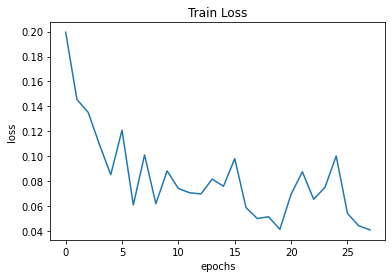

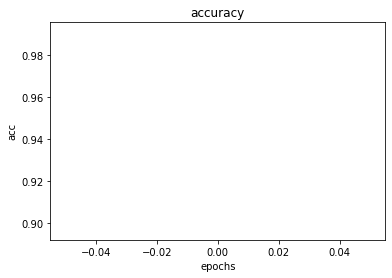

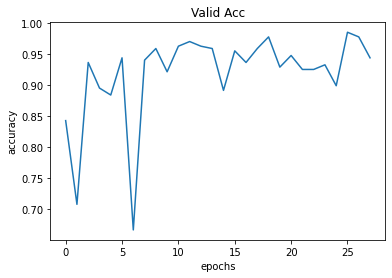

In [21]:
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_dinamic_M3V_drn_.pth')
test_acc = test(net, test_loader, loss_fn)
EndTime = time.time()
print('Time Usage: ', str(datetime.timedelta(seconds=int(round(EndTime-StartTime)))))



plt.figure()
plt.plot(loss)
plt.title('Train Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
plt.figure()

plt.plot(valid_acc)
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.show()

plt.figure()
plt.plot(val_acc)
plt.title('Valid Acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

# Grad Cam

In [11]:
count = 0
net = CNNX1().to(device)
learning_rate = 0.0001
optimizer = Ranger(net.parameters())
loss_fn = Focal_Loss()
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_dinamic_MV_drn_.pth')
print('test model ready')

from load_data import *

testing_0 = list(glob.glob('/home/ubuntu/Andrew/lung_datatset/test/noPE/19743272/*'))
testing_1 = list(glob.glob('/home/ubuntu/Andrew/lung_datatset/test/PE/04517051/*'))
testing_data, _, _ = get_data(testing_0, testing_1, 1)
Testing_Set = mv_loader(list(testing_data), transform = None)
print('testing set ready')
testing_loader = DataLoader(Testing_Set, batch_size=test_bs, shuffle = False,
                      num_workers=8, pin_memory=True)
test_acc = test(net, testing_loader, loss_fn)


for data_def, data_lung, m, target in testing_loader:
    print("slice:",count)
    count = count+1
    data_def, data_lung, target = data_def.to(device), data_lung.to(device), target.to(device)
    output = net(data_def, data_lung).data
    pred = output.data.max(1, keepdim=True)[1]
    print(pred)

load /home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_dinamic_MV_drn_.pth
set state called
test model ready
13 6
testing set ready

Test set: Average loss: 0.0263, Accuracy: 18/19 (95%), Triage_acc: (6), WNL_acc: (12)

slice: 0
tensor([[0],
        [0],
        [0],
        [0]], device='cuda:0')
slice: 1
tensor([[0],
        [0],
        [0],
        [0]], device='cuda:0')
slice: 2
tensor([[0],
        [0],
        [0],
        [0]], device='cuda:0')
slice: 3
tensor([[1],
        [1],
        [1],
        [1]], device='cuda:0')
slice: 4
tensor([[1],
        [1],
        [1]], device='cuda:0')


In [42]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

model = net.to(device)
target_layer = model.model_d.layer8[-1]
input_tensor = Testing_Set# Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layer=target_layer)

# If target_category is None, the highest scoring category
# will be used for every image in the batch.
# target_category can also be an integer, or a list of different integers
# for every image in the batch.
target_category = 2

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor,  target_category=target_category)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam)

TypeError: forward() missing 1 required positional argument: 'input_lung'

# 2View DRN

load /home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_dinamic_MV_drn_.pth
set state called

Test set: Average loss: 0.0089, Accuracy: 179/180 (99%), Triage_acc: (48), WNL_acc: (131)

Time Usage:  0:25:07


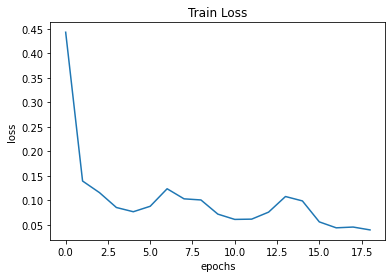

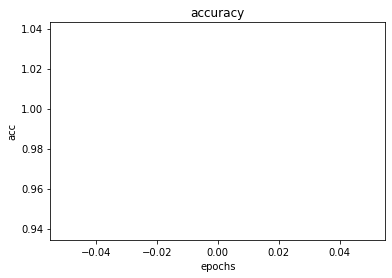

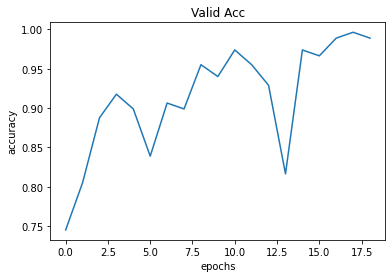

In [16]:
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_dinamic_MV_drn_.pth')
test_acc = test(net, test_loader, loss_fn)
EndTime = time.time()
print('Time Usage: ', str(datetime.timedelta(seconds=int(round(EndTime-StartTime)))))



plt.figure()
plt.plot(loss)
plt.title('Train Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
plt.figure()

plt.plot(valid_acc)
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.show()

plt.figure()
plt.plot(val_acc)
plt.title('Valid Acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

# dinamic crop drn

load /home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_dinamic_cut_drn_.pth
set state called

Test set: Average loss: 0.0213, Accuracy: 176/180 (98%), PE_acc: (46), noPE_acc: (130)

Time Usage:  0:24:56


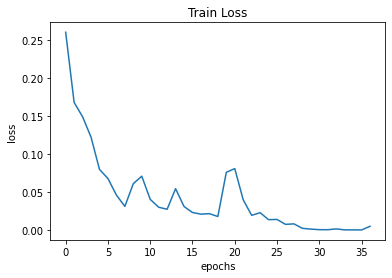

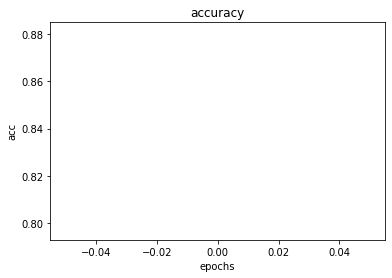

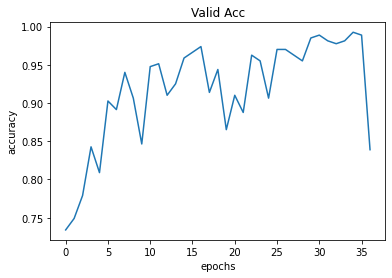

In [28]:
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_dinamic_cut_drn_.pth')
test_acc = test(net, test_loader, loss_fn)
EndTime = time.time()
print('Time Usage: ', str(datetime.timedelta(seconds=int(round(EndTime-StartTime)))))



plt.figure()
plt.plot(loss)
plt.title('Train Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
plt.figure()

plt.plot(valid_acc)
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.show()

plt.figure()
plt.plot(val_acc)
plt.title('Valid Acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

# Canny edge drn

load /home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_canny_drn_.pth
set state called

Test set: Average loss: 0.2019, Accuracy: 132/166 (80%), PE_acc: (0), noPE_acc: (132)

Time Usage:  0:36:22


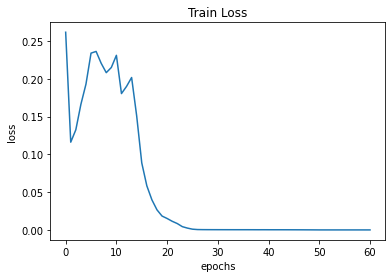

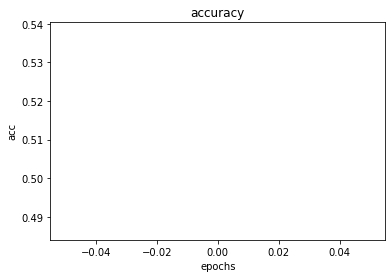

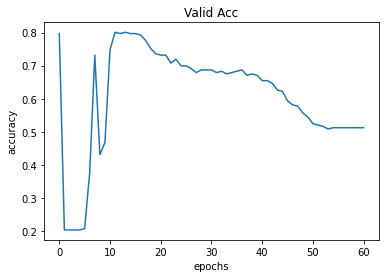

In [59]:
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_canny_drn_.pth')
test_acc = test(net, test_loader, loss_fn)
EndTime = time.time()
print('Time Usage: ', str(datetime.timedelta(seconds=int(round(EndTime-StartTime)))))



plt.figure()
plt.plot(loss)
plt.title('Train Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
plt.figure()

plt.plot(valid_acc)
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.show()

plt.figure()
plt.plot(val_acc)
plt.title('Valid Acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

## ResNet 50 (50epoch) 

In [ ]:
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_0606_.pth')
test_acc = test(net, test_loader, loss_fn)
'''
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_resbest_acc_A1_.pth')
test_acc = test(net, test_loader, loss_fn)
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/drn_10.pth')
test_acc = test(net, test_loader, loss_fn)
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/drn_20.pth')
test_acc = test(net, test_loader, loss_fn)
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/drn_30.pth')
test_acc = test(net, test_loader, loss_fn)
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/drn_40.pth')
test_acc = test(net, test_loader, loss_fn)
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/drn_50.pth')
test_acc = test(net, test_loader, loss_fn)
#test_acc, y, y_score, y_pred = test(net, test_loader, loss_fn)

y = np.array(y)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

precision = precision_score(y, y_pred, average='weighted')
recall = recall_score(y, y_pred, average='weighted')
print('precision', precision, 'recall', recall)
ftr, tpr, _ = roc_curve(y, y_pred)
roc_auc = auc(ftr, tpr)
print('auc', roc_auc)
'''
EndTime = time.time()
print('Time Usage: ', str(datetime.timedelta(seconds=int(round(EndTime-StartTime)))))



plt.figure()
plt.plot(loss)
plt.title('Train Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
plt.figure()

plt.plot(valid_acc)
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.show()

plt.figure()
plt.plot(val_acc)
plt.title('Valid Acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

## ResNet 50 (250 epoch)

In [ ]:
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_0606_1_.pth')
test_acc = test(net, test_loader, loss_fn)
EndTime = time.time()
print('Time Usage: ', str(datetime.timedelta(seconds=int(round(EndTime-StartTime)))))



plt.figure()
plt.plot(loss)
plt.title('Train Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.plot(valid_acc)
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.show()

plt.figure()
plt.plot(val_acc)
plt.title('Valid Acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

## DRN 150 epoch

In [ ]:
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_0606_a_.pth')
test_acc = test(net, test_loader, loss_fn)
EndTime = time.time()
print('Time Usage: ', str(datetime.timedelta(seconds=int(round(EndTime-StartTime)))))



plt.figure()
plt.plot(loss)
plt.title('Train Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.plot(valid_acc)
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.show()

plt.figure()
plt.plot(val_acc)
plt.title('Valid Acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

## DRN 250 epoch

In [ ]:
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_0607_drn_.pth')
test_acc = test(net, test_loader, loss_fn)
EndTime = time.time()
print('Time Usage: ', str(datetime.timedelta(seconds=int(round(EndTime-StartTime)))))



plt.figure()
plt.plot(loss)
plt.title('Train Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.plot(valid_acc)
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.show()

plt.figure()
plt.plot(val_acc)
plt.title('Valid Acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

## DRN 250 epoch ranger

In [ ]:
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_0607_drn_ranger_.pth')
test_acc = test(net, test_loader, loss_fn)
EndTime = time.time()
print('Time Usage: ', str(datetime.timedelta(seconds=int(round(EndTime-StartTime)))))



plt.figure()
plt.plot(loss)
plt.title('Train Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.plot(valid_acc)
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.show()

plt.figure()
plt.plot(val_acc)
plt.title('Valid Acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

## EfficientNet V3

In [ ]:
optimizer = Ranger(net.parameters())
loss_fn = Focal_Loss()
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_0608_eff_.pth')
test_acc = test(net, test_loader, loss_fn)
EndTime = time.time()
print('Time Usage: ', str(datetime.timedelta(seconds=int(round(EndTime-StartTime)))))



plt.figure()
plt.plot(loss)
plt.title('Train Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.plot(valid_acc)
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.show()

plt.figure()
plt.plot(val_acc)
plt.title('Valid Acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

# PER patient BEST

In [11]:
count = 1
net = CNNX1().to(device)
learning_rate = 0.0001
optimizer = Ranger(net.parameters())
loss_fn = Focal_Loss()
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_dinamic_MV_drn_.pth')
print('test model ready')

from load_data import *

testing_0 = list(glob.glob('/home/ubuntu/Andrew/lung_datatset/test/noPE/19743272/*'))
testing_1 = list(glob.glob('/home/ubuntu/Andrew/lung_datatset/test/PE/04517051/*'))
testing_data, _, _ = get_data(testing_0, testing_1, 1)
Testing_Set = mv_loader(list(testing_data), transform = None)
print('testing set ready')
testing_loader = DataLoader(Testing_Set, batch_size=test_bs, shuffle = False,
                      num_workers=8, pin_memory=True)
test_acc = test(net, testing_loader, loss_fn)


for data_def, data_lung, m, target in testing_loader:
    print("slice:",count)
    count = count+1
    data_def, data_lung, target = data_def.to(device), data_lung.to(device), target.to(device)
    output = net(data_def, data_lung).data
    #pred = output.data.max(1, keepdim=True)[1]
    print(output)
    

load /home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_dinamic_MV_drn_.pth
set state called
test model ready
13 6
testing set ready

Test set: Average loss: 0.0263, Accuracy: 18/19 (95%), Triage_acc: (6), WNL_acc: (12)

slice: 1
tensor([[ 4.3475, -3.7646],
        [ 6.4817, -6.0988],
        [ 4.1567, -3.6320],
        [ 6.2336, -5.7567]], device='cuda:0')
slice: 2
tensor([[ 4.3111, -3.8129],
        [ 5.9058, -5.4295],
        [ 6.7043, -6.1995],
        [ 6.3591, -5.9095]], device='cuda:0')
slice: 3
tensor([[ 5.9246, -5.5462],
        [ 3.0439, -2.5862],
        [ 4.5652, -4.1455],
        [ 6.4581, -6.0401]], device='cuda:0')
slice: 4
tensor([[-0.0447,  0.4595],
        [-0.5637,  0.7888],
        [-2.0896,  2.2456],
        [-0.8957,  1.0669]], device='cuda:0')
slice: 5
tensor([[-1.8045,  1.9519],
        [-2.7991,  2.8434],
        [-2.3995,  2.4493]], device='cuda:0')


# Per patient WNL1

In [29]:
testing_0 = list(glob.glob('/home/ubuntu/Andrew/lung_datatset/test/WNL/*'))
testing_1 = list(glob.glob('/home/ubuntu/Andrew/lung_datatset/test/noPE/*'))
testing_data, _, _ = get_data(testing_0, testing_1, 1)
Testing_Set = PE_transform(list(testing_data), transform = None)
testing_loader = DataLoader(Testing_Set, batch_size=test_bs, shuffle = False,
                      num_workers=8, pin_memory=True)

79 0


In [ ]:
net = CNNX1().to(device)
learning_rate = 0.0001
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
#optimizer = Ranger(net.parameters())

### DRN

In [30]:
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_dinamic_cut_drn_.pth')
testing_acc = test(net, testing_loader, loss_fn)

load /home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_dinamic_cut_drn_.pth
set state called

Test set: Average loss: 0.0279, Accuracy: 73/79 (92%), PE_acc: (0), noPE_acc: (73)



# Per patient no_PE

In [31]:
testing_0 = list(glob.glob('/home/ubuntu/Andrew/lung_datatset/test/WNL/*'))
testing_1 = list(glob.glob('/home/ubuntu/Andrew/lung_datatset/test/noPE/*'))
testing_data, _, _ = get_data(testing_0, testing_1, 1)
Testing_Set = PE_transform(list(testing_data), transform = None)
testing_loader = DataLoader(Testing_Set, batch_size=test_bs, shuffle = False,
                      num_workers=8, pin_memory=True)

93 10


In [ ]:
 torch.cuda.empty_cache()

In [ ]:
testing_0 = list(glob.glob('/home/ubuntu/Andrew/CT_CLA/v0/*'))
testing_1 = list(glob.glob('/home/ubuntu/Andrew/CT_CLA/v1/*'))
testing_data, _, _ = get_data(testing_0, testing_1, 1)
Testing_Set = PE_transform(list(testing_data), transform = None)
testing_loader = DataLoader(Testing_Set, batch_size=test_bs, shuffle = False,
                      num_workers=8, pin_memory=True)

NEW_dataset/20210604

In [ ]:
testing_0 = list(glob.glob('/home/ubuntu/Andrew/lung_datatset/WNL/*'))
testing_1 = list(glob.glob('/home/ubuntu/Andrew/lung_datatset/no_PE/*'))
testing_data, _, _ = get_data(testing_0, testing_1, 1)
Testing_Set = PE_transform(list(testing_data), transform = None)
testing_loader = DataLoader(Testing_Set, batch_size=test_bs, shuffle = False,
                      num_workers=8, pin_memory=True)

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)
loss_fn = Focal_Loss()

In [ ]:
#net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_resbest_acc_A1_.pth')
#testing_acc = test(net, testing_loader, loss_fn)

net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/drn_10.pth')
testing_acc = test(net, testing_loader, loss_fn)
'''
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/drn_20.pth')
testing_acc = test(net, testing_loader, loss_fn)
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/drn_30.pth')
testing_acc = test(net, testing_loader, loss_fn)
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/drn_40.pth')
testing_acc = test(net, testing_loader, loss_fn)
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/drn_50.pth')
testing_acc = test(net, testing_loader, loss_fn)
'''